In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from PIL import Image
import os
import cv2
from glob import glob
import random
import torch
from torch.utils.data import Dataset, DataLoader
from tqdm.notebook import tqdm
from torch import nn
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score, recall_score, precision_score, f1_score

In [2]:
random.seed(42)
np.random.seed(42)
torch.manual_seed(0)

In [3]:
df = pd.read_csv("../datasets/waterbird/metadata.csv")
df.head(5)

,img_id,img_filename,y,split,place,place_filename
0,1,001.Black_footed_Albatross/Black_Footed_Albatr...,1,2,1,/o/ocean/00002178.jpg
1,2,001.Black_footed_Albatross/Black_Footed_Albatr...,1,0,1,/l/lake/natural/00000065.jpg
2,3,001.Black_footed_Albatross/Black_Footed_Albatr...,1,2,0,/b/bamboo_forest/00000131.jpg
3,4,001.Black_footed_Albatross/Black_Footed_Albatr...,1,0,1,/o/ocean/00001268.jpg
4,5,001.Black_footed_Albatross/Black_Footed_Albatr...,1,0,1,/o/ocean/00003147.jpg


In [4]:
LANDBIRD = 0
WATERBIRD = 1
LAND = 0
WATER = 1

In [5]:
def get_result(result_file: str):
    performance_report = np.load(result_file, allow_pickle=True)

    true_labels = [x['img_label'] for x in performance_report]
    predicted_labels = [x['predicted'] for x in performance_report]
    place = [x['place'] for x in performance_report]

    landbird_on_land = []
    landbird_on_water = []
    waterbird_on_land = []
    waterbird_on_water = []

    predicted_landbird_on_land = []
    predicted_landbird_on_water = []
    predicted_waterbird_on_land = []
    predicted_waterbird_on_water = []

    predicted_landbird_on_land_correct = []
    predicted_landbird_on_land_incorrect = []

    predicted_landbird_on_water_correct = []
    predicted_landbird_on_water_incorrect = []

    predicted_waterbird_on_land_correct = []
    predicted_waterbird_on_land_incorrect = []

    predicted_waterbird_on_water_correct = []
    predicted_waterbird_on_water_incorrect = []

    for report in performance_report:
        if report['img_label'] == LANDBIRD and report['place'] == LAND:
            landbird_on_land.append(report['img_label'])
            predicted_landbird_on_land.append(report['predicted'])
            if report['img_label'] == report['predicted']:
                predicted_landbird_on_land_correct.append(report)
            else:
                predicted_landbird_on_land_incorrect.append(report)

        elif report['img_label'] == LANDBIRD and report['place'] == WATER:
            landbird_on_water.append(report['img_label'])
            predicted_landbird_on_water.append(report['predicted'])
            if report['img_label'] == report['predicted']:
                predicted_landbird_on_water_correct.append(report)
            else:
                predicted_landbird_on_water_incorrect.append(report)

        elif report['img_label'] == WATERBIRD and report['place'] == LAND:
            waterbird_on_land.append(report['img_label'])
            predicted_waterbird_on_land.append(report['predicted'])
            if report['img_label'] == report['predicted']:
                predicted_waterbird_on_land_correct.append(report)
            else:
                predicted_waterbird_on_land_incorrect.append(report)

        elif report['img_label'] == WATERBIRD and report['place'] == WATER:
            waterbird_on_water.append(report['img_label'])
            predicted_waterbird_on_water.append(report['predicted'])
            if report['img_label'] == report['predicted']:
                predicted_waterbird_on_water_correct.append(report)
            else:
                predicted_waterbird_on_water_incorrect.append(report)



    test_acc = accuracy_score(true_labels, predicted_labels)
    landbird_on_land_acc = accuracy_score(landbird_on_land, predicted_landbird_on_land)
    landbird_on_water_acc = accuracy_score(landbird_on_water, predicted_landbird_on_water)
    waterbird_on_water_acc = accuracy_score(waterbird_on_water, predicted_waterbird_on_water)
    waterbird_on_land_acc = accuracy_score(waterbird_on_land, predicted_waterbird_on_land)

    test_f1 = f1_score(true_labels, predicted_labels, average='macro')
    landbird_on_land_f1 = f1_score(landbird_on_land, predicted_landbird_on_land, average='macro')
    landbird_on_water_f1 = f1_score(landbird_on_water, predicted_landbird_on_water, average='macro')
    waterbird_on_water_f1 = f1_score(waterbird_on_water, predicted_waterbird_on_water, average='macro')
    waterbird_on_land_f1 = f1_score(waterbird_on_land, predicted_waterbird_on_land, average='macro')

    # print(f"All data\nAccuracy: {test_acc:.2f} | F1 Score: {test_f1:.2f}")
    # print(f"Landbird on land\nAccuracy: {landbird_on_land_acc:.2f} | F1 Score: {landbird_on_land_f1:.2f}")
    # print(f"Landbird on water\nAccuracy: {landbird_on_water_acc:.2f} | F1 Score: {landbird_on_water_f1:.2f}")
    # print(f"Waterbird on water\nAccuracy: {waterbird_on_water_acc:.2f} | F1 Score: {waterbird_on_water_f1:.2f}")
    # print(f"Waterbird on land\nAccuracy: {waterbird_on_land_acc:.2f} | F1 Score: {waterbird_on_land_f1:.2f}")

    return test_acc, landbird_on_land_acc, landbird_on_water_acc, waterbird_on_land_acc, waterbird_on_water_acc, test_f1, landbird_on_land_f1, landbird_on_water_f1, waterbird_on_land_f1, waterbird_on_water_f1

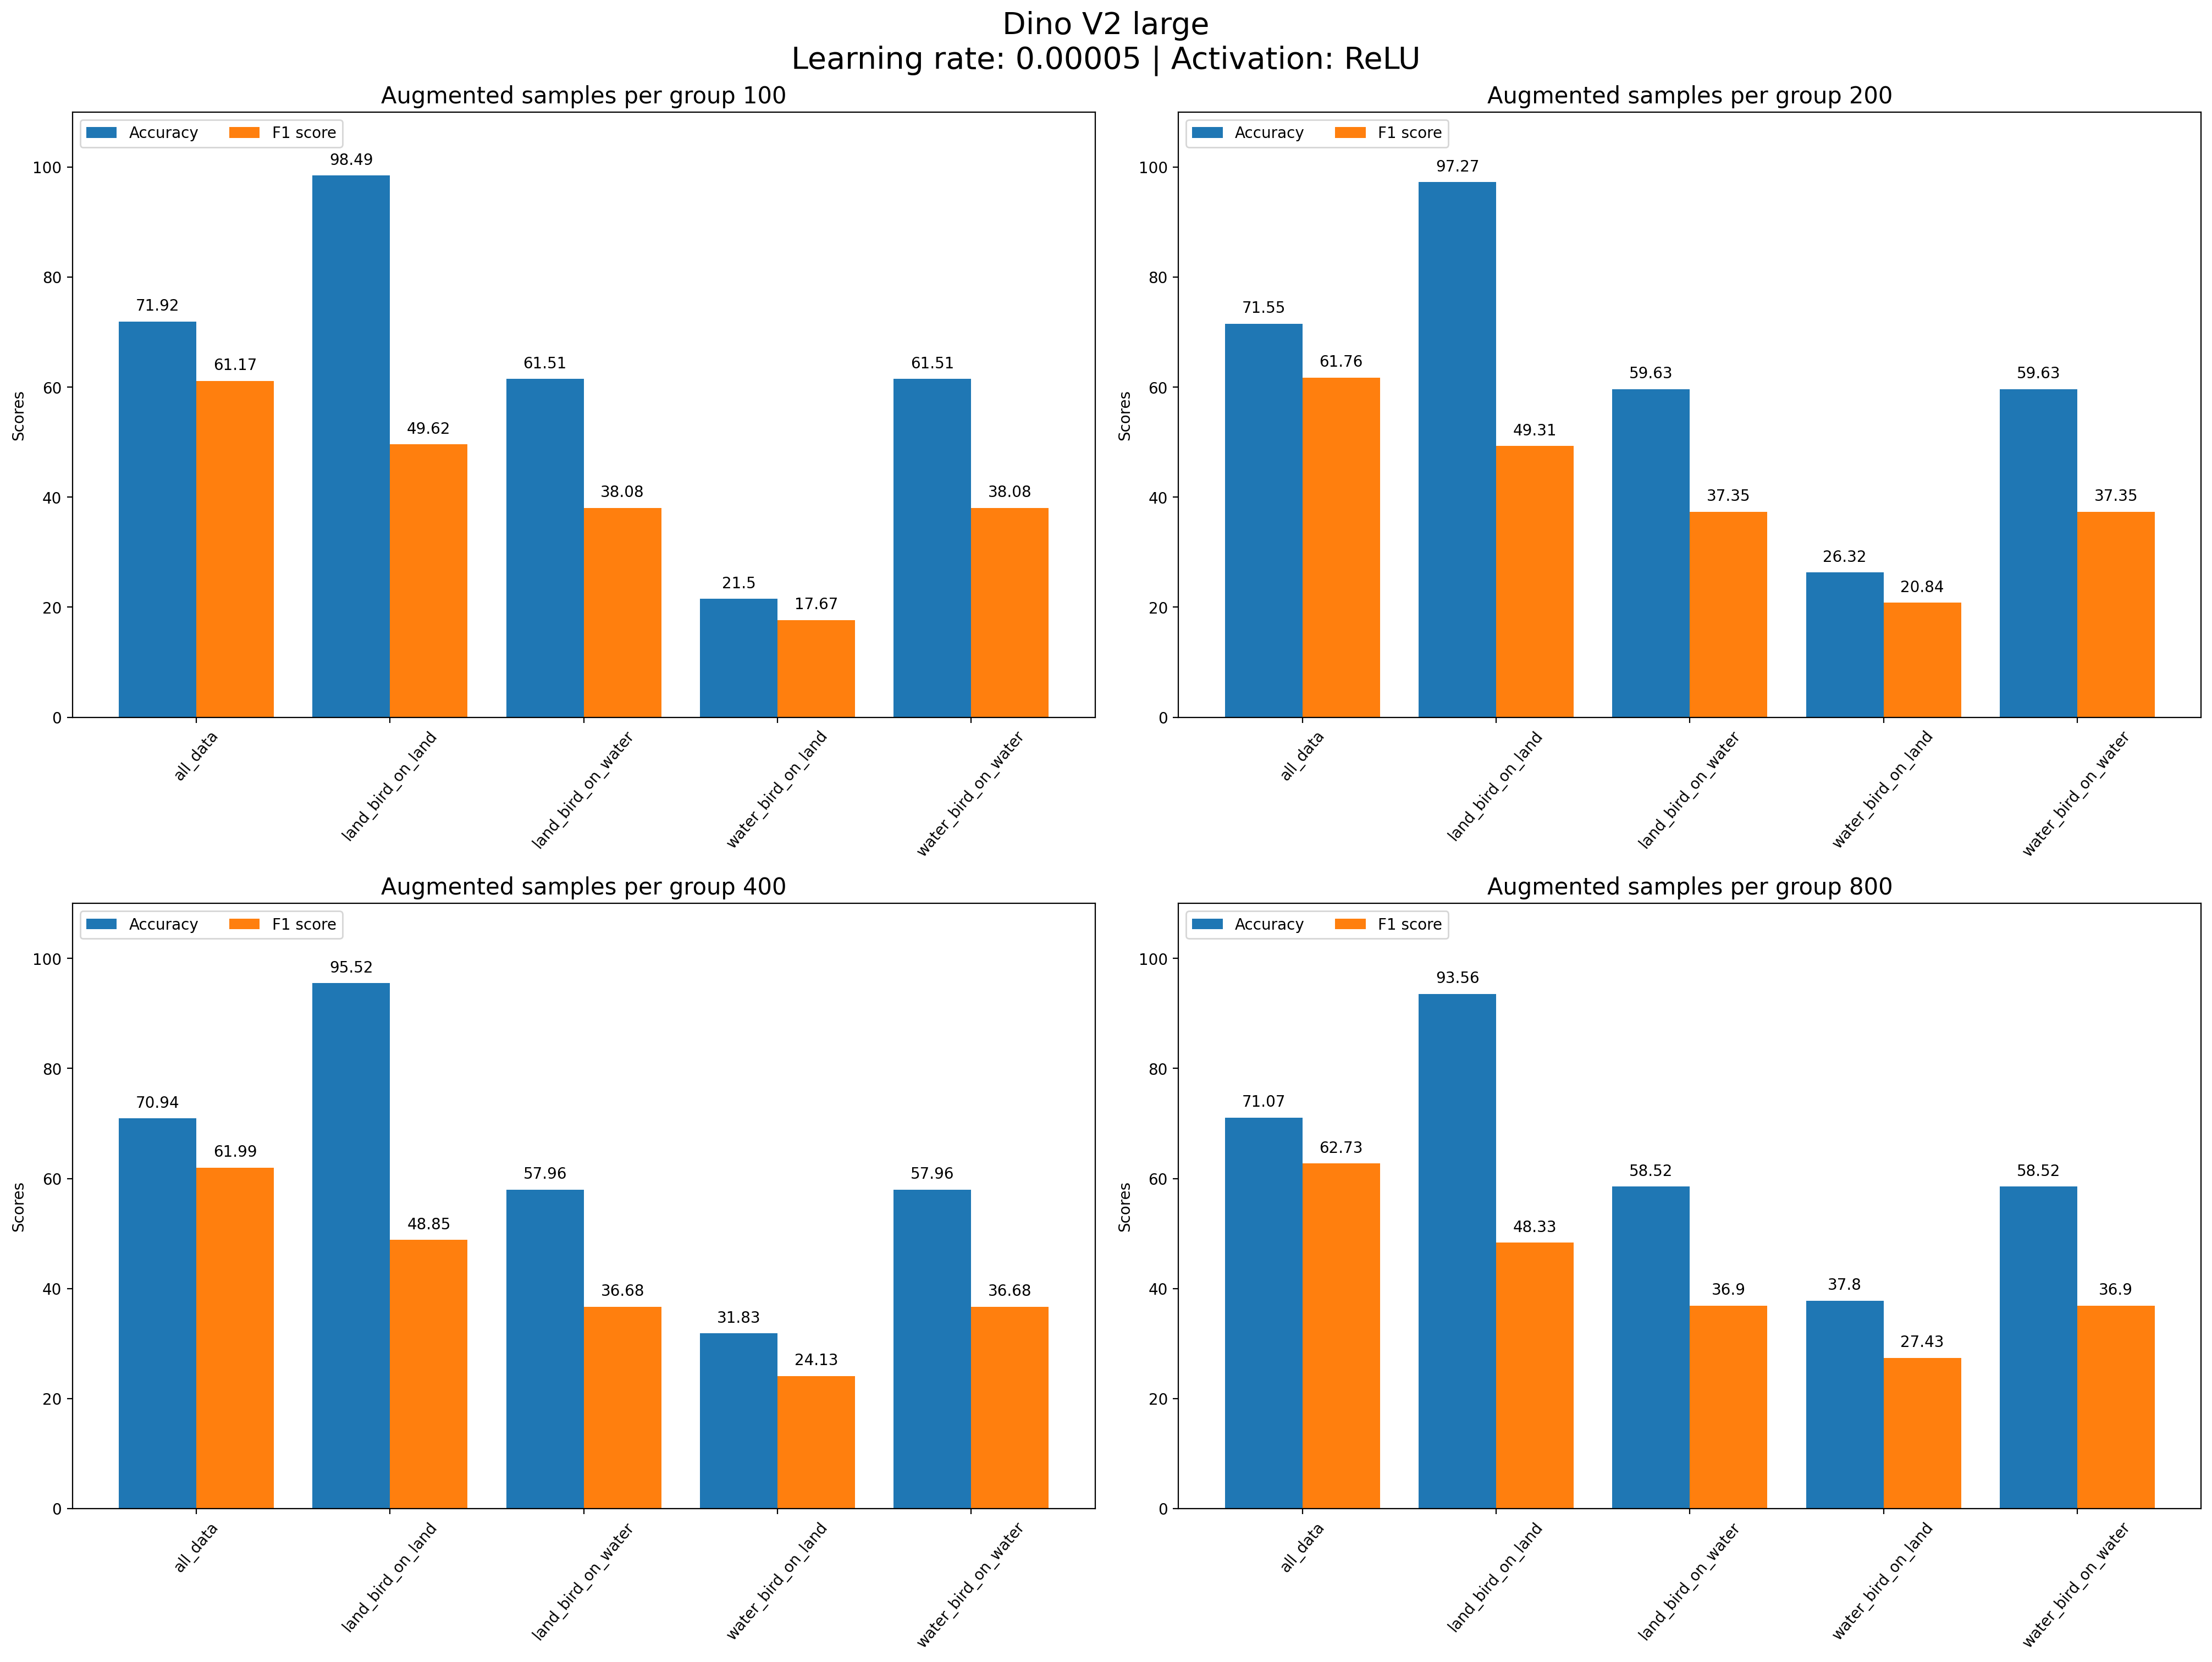

In [11]:
fig, axs = plt.subplots(2, 2, layout='constrained', figsize=(20, 15), dpi=200)
axs = axs.flatten()
folder_name = 'lr_00005_relu'
plt.suptitle('Dino V2 large\nLearning rate: 0.00005 | Activation: ReLU', fontsize=20)

for idx, sample_size in enumerate([100, 200, 400, 800]):
    test_accs = []
    landbird_on_land_accs = []
    landbird_on_water_accs = []
    waterbird_on_land_accs = []
    waterbird_on_water_accs = []
    test_f1s = []
    landbird_on_land_f1s = []
    landbird_on_water_f1s = []
    waterbird_on_water_f1s = []
    waterbird_on_land_f1s = []

    for j in range(1, 4):
        sample = f'{sample_size}_sample_{j}'
        # print(f'------------{sample}-----------')
        test_acc, landbird_on_land_acc, \
        landbird_on_water_acc, waterbird_on_land_acc, \
        waterbird_on_water_acc, test_f1, \
        landbird_on_land_f1, landbird_on_water_f1, \
        waterbird_on_land_f1, waterbird_on_water_f1 = get_result(f"./dino_v2_large/statistics/{folder_name}/inference_stats/{sample}.npy")
        
        test_accs.append(test_acc)
        landbird_on_land_accs.append(landbird_on_land_acc)
        landbird_on_water_accs.append(landbird_on_water_acc)
        waterbird_on_land_accs.append(waterbird_on_land_acc)
        waterbird_on_water_accs.append(waterbird_on_water_acc)

        test_f1s.append(test_f1)
        landbird_on_land_f1s.append(landbird_on_land_f1)
        landbird_on_water_f1s.append(landbird_on_water_f1)
        waterbird_on_land_f1s.append(waterbird_on_land_f1)
        waterbird_on_water_f1s.append(waterbird_on_water_f1)

    avg_test_acc = np.average(test_accs)
    avg_landbird_on_land_acc = np.average(landbird_on_land_accs)
    avg_landbird_on_water_acc = np.average(landbird_on_water_accs)
    avg_waterbird_on_land_acc = np.average(waterbird_on_land_accs)
    avg_waterbird_on_water_acc = np.average(waterbird_on_water_accs)

    avg_test_f1 = np.average(test_f1s)
    avg_landbird_on_land_f1 = np.average(landbird_on_land_f1s)
    avg_landbird_on_water_f1 = np.average(landbird_on_water_f1s)
    avg_waterbird_on_land_f1 = np.average(waterbird_on_land_f1s)
    avg_waterbird_on_water_f1 = np.average(waterbird_on_water_f1s)
    

    splits = ("all_data", "land_bird_on_land",
          "land_bird_on_water", "water_bird_on_land", "water_bird_on_water")

    scores = {
        'Accuracy': (avg_test_acc, avg_landbird_on_land_acc, avg_landbird_on_water_acc, avg_waterbird_on_land_acc, avg_landbird_on_water_acc),
        'F1 score': (avg_test_f1, avg_landbird_on_land_f1, avg_landbird_on_water_f1, avg_waterbird_on_land_f1, avg_landbird_on_water_f1),
    }

    x = np.arange(len(splits))
    width = 0.4
    multiplier = 0
    

    for attribute, measurement in scores.items():
        measurement = [round(x * 100, 2) for x in measurement]
        offset = width * multiplier 
        rects = axs[idx].bar(x + offset, measurement, width, label=attribute)
        axs[idx].bar_label(rects, padding=5)
        multiplier += 1

    axs[idx].set_ylabel('Scores')
    axs[idx].set_title(f'Augmented samples per group {sample_size}', fontsize=15)
    axs[idx].set_xticks(x + width / 2, splits)
    axs[idx].set_xticklabels(splits, rotation=50)
    axs[idx].legend(loc='upper left', ncols=2)
    axs[idx].set_ylim(0, 110)


plt.show()